In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
import torch
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn import decomposition

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
g = torch.Generator()
g.manual_seed(42)

In [3]:
class WeatherBenchDatasetWindow(Dataset):
    def __init__(
        self,
        data,
        context_length,
        target_length,
        stride=1,
        mask_prob_low=0.7,
        mask_prob_high=0.7,
    ):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx]
        return x

In [4]:
model = torch.load(
    "det_autoencoder.pth", weights_only=False, map_location=DEVICE
)
model.eval()

BATCH_SIZE = 128
data = torch.load("/vol/bitbucket/nb324/era5_level0.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.8)
train_data = data[:n_train]
test_data = data[n_train:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std

test_dataset = WeatherBenchDatasetWindow(
    data=test_data,
    context_length=30,
    target_length=1,
    stride=1,
    mask_prob_low=0.7,
    mask_prob_high=0.7,
)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
batch = next(iter(testloader))
data = batch.to(DEVICE)
print(data.shape)
with torch.no_grad():
    model_data = model(data)

torch.Size([128, 5, 64, 32])


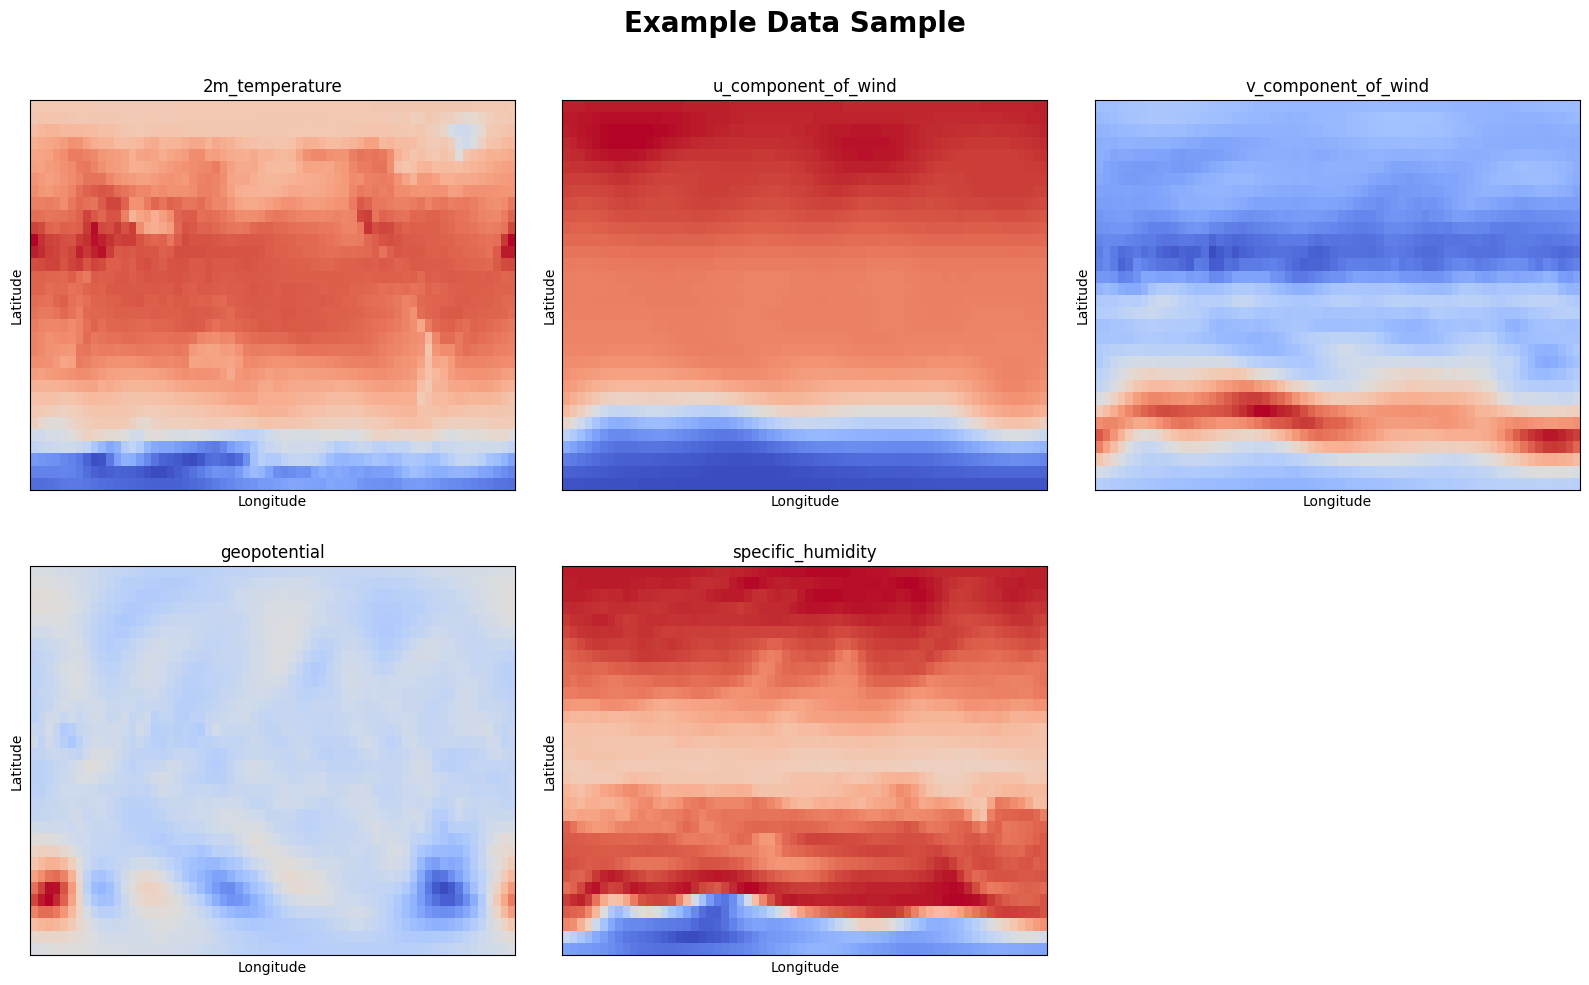

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

axs[0, 0].imshow(
    np.rot90(data[0, 0, :, :].unsqueeze(0).permute(1, 2, 0).cpu().numpy()),
    cmap="coolwarm",
    aspect="auto",
)
axs[0, 0].set_title("2m_temperature")

axs[0, 1].imshow(
    np.rot90(data[0, 1, :, :].unsqueeze(0).permute(1, 2, 0).cpu().numpy()),
    cmap="coolwarm",
    aspect="auto",
)
axs[0, 1].set_title("u_component_of_wind")

axs[0, 2].imshow(
    np.rot90(data[0, 2, :, :].unsqueeze(0).permute(1, 2, 0).cpu().numpy()),
    cmap="coolwarm",
    aspect="auto",
)
axs[0, 2].set_title("v_component_of_wind")

axs[1, 0].imshow(
    np.rot90(data[0, 3, :, :].unsqueeze(0).permute(1, 2, 0).cpu().numpy()),
    cmap="coolwarm",
    aspect="auto",
)
axs[1, 0].set_title("geopotential")

axs[1, 1].imshow(
    np.rot90(data[0, 4, :, :].unsqueeze(0).permute(1, 2, 0).cpu().numpy()),
    cmap="coolwarm",
    aspect="auto",
)
axs[1, 1].set_title("specific_humidity")

axs[1, 2].axis("off")

for ax in axs.flatten():
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xticks([])
    ax.set_yticks([])


fig.suptitle("Example Data Sample", fontsize=20, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97], w_pad=2.0, h_pad=2.5)
plt.show()

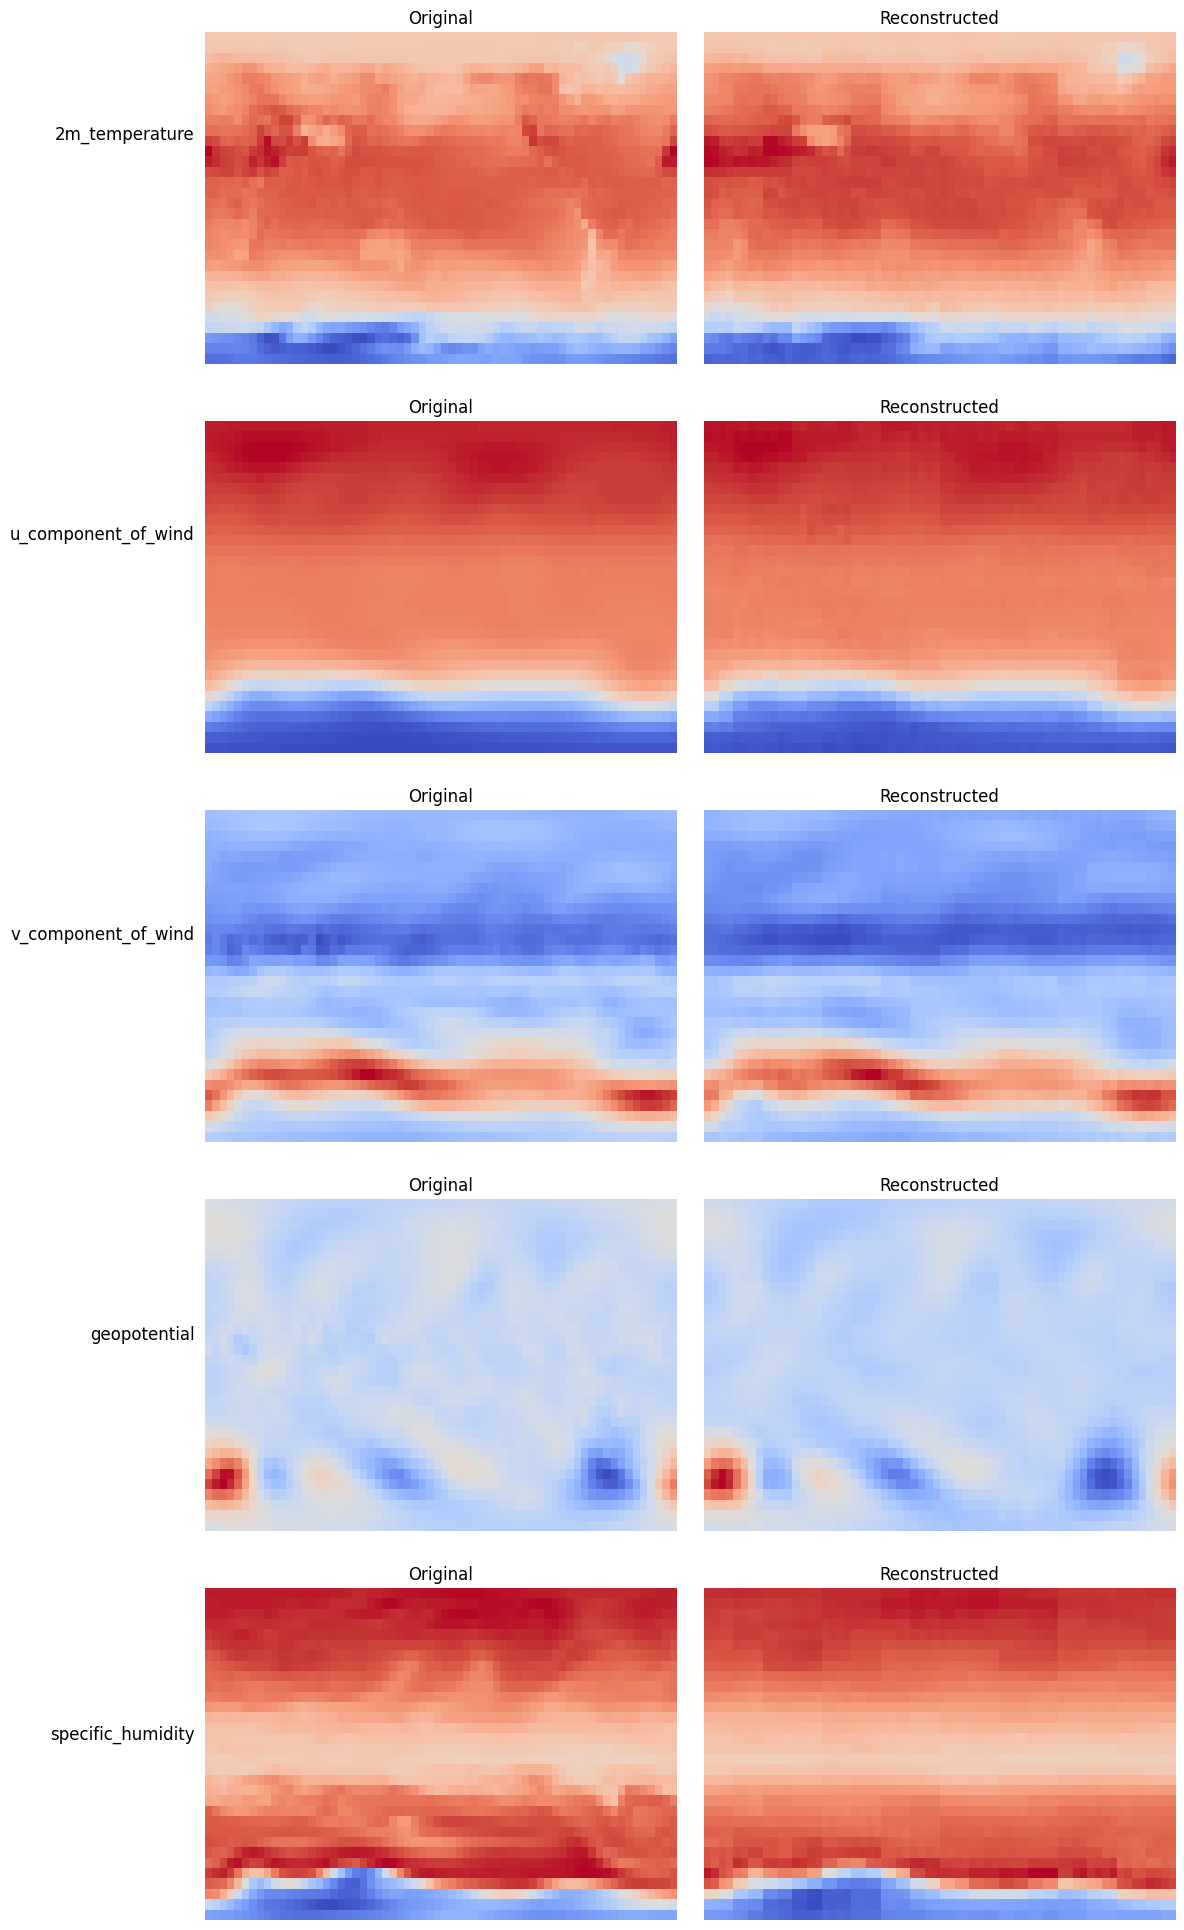

In [7]:
mode_labels = [
    "2m_temperature",
    "u_component_of_wind",
    "v_component_of_wind",
    "geopotential",
    "specific_humidity",
]

fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    axs[i, 0].imshow(
        np.rot90(
            data[0, i, :, :].unsqueeze(0).permute(1, 2, 0).cpu().numpy()
        ),
        cmap="coolwarm",
        aspect="auto",
    )
    axs[i, 0].set_title("Original")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(
        np.rot90(
            model_data[0, i, :, :].unsqueeze(0).permute(1, 2, 0).cpu().numpy()
        ),
        cmap="coolwarm",
        aspect="auto",
    )
    axs[i, 1].set_title("Reconstructed")
    axs[i, 1].axis("off")

for i in range(5):
    fig.text(
        0.005,
        1 - (i + 0.5) / 5,
        mode_labels[i],
        va="center",
        ha="right",
        fontsize=12,
    )
plt.tight_layout(rect=[0, 0, 1, 0.97], w_pad=2.0, h_pad=2.5)
plt.show()

In [8]:
test_batch = next(iter(testloader))

X = test_batch.to(DEVICE)[:20]

with torch.no_grad():
    embeddings_x = model.encoder(X).cpu()

pca = decomposition.PCA(n_components=2)
embeddings_x = pca.fit_transform(embeddings_x)

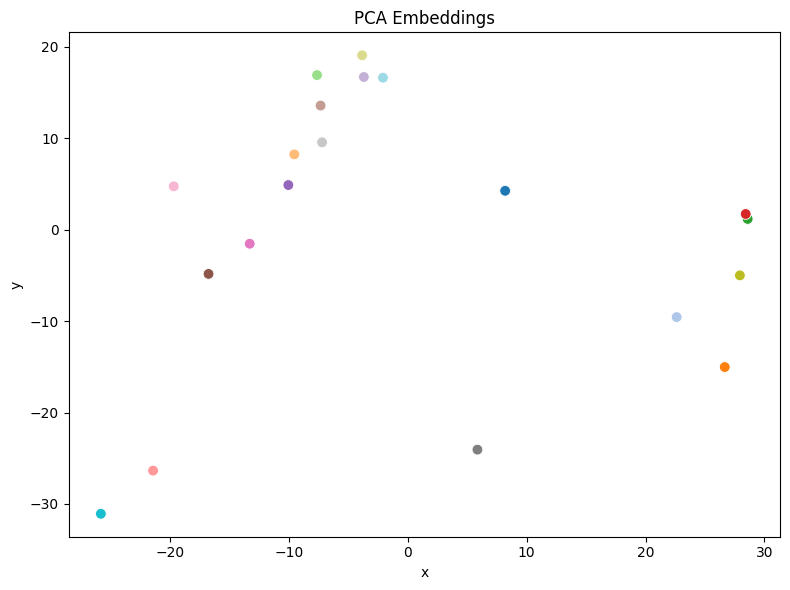

In [9]:
df = pd.DataFrame(
    {
        "x": embeddings_x[:, 0],
        "y": embeddings_x[:, 1],
        "point_id": list(range(20)),
    }
)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue="point_id", palette="tab20", s=60)
plt.legend().remove()
plt.title("PCA Embeddings")
plt.tight_layout()